# 教程9: 细胞通讯分析

由于我们前面推测STER cells会调控视神经的破坏，所以在这里，我们使用`CellphoneDB`数据库分析了STER cells与视神经细胞之间的关系。

## 1. CellPhoneDB数据准备

由于CellPhoneDB并不能直接使用scanpy等包分析，我们需要从我们的单细胞数据中导出相关CellPhoneDB需要的数据格式：

- counts.tsv
- meta.tsv

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys
from scipy import sparse
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sys.executable

'/home/leihu/pyomic/bin/python'

In [2]:
current_path='/home/leihu/data/analysis/rb_tutorial/'

### 1.1 读取注释好的文件

In [7]:
#neuron是我们注释好的视神经数据
adata=sc.read(current_path+'data/analysis4/neuron.h5ad')
adata.obs['major_celltype1'].unique()

['MGC-Immune', 'Astrocytes CLU+', 'Astrocytes KRT19+', 'MGC-Stressed', 'Middle Glial cells', ..., 'Microglial cells', 'MGC-Normal', 'Dendritic cells', 'T cells', 'Immune RPE cells']
Length: 11
Categories (11, object): ['Astrocytes CLU+', 'Astrocytes KRT19+', 'Dendritic cells', 'Immune RPE cells', ..., 'MGC-Stressed', 'Microglial cells', 'Middle Glial cells', 'T cells']

In [8]:
#phone是我们注释好的视网膜数据，我们需要从中提取STER细胞
adata1=sc.read(current_path+'data/analysis3/photo_anno.h5ad')
adata1=adata1[adata1.obs['major_celltype1']=='STER cells']
adata1.obs['major_celltype1'].unique()

/home/leihu/pyomic/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph'] that happens to be dimensioned at n_obs×n_obs (13315×13315).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(
/home/leihu/pyomic/lib/python3.8/site-packages/anndata/compat/__init__.py:263: FutureWarning: During AnnData slicing, found matrix at .uns['velocity_graph_neg'] that happens to be dimensioned at n_obs×n_obs (13315×13315).

These matrices should now be stored in the .obsp attribute.
This slicing behavior will be removed in anndata 0.8.
  warn(


['STER cells']
Categories (1, object): ['STER cells']

### 1.2 合并文件

In [9]:
import anndata
adata_new=anndata.concat([adata,adata1],merge='same')
adata_new.obs['major_celltype1'].unique()

array(['MGC-Immune', 'Astrocytes CLU+', 'Astrocytes KRT19+',
       'MGC-Stressed', 'Middle Glial cells', 'MGC-Profiled',
       'Microglial cells', 'MGC-Normal', 'Dendritic cells', 'T cells',
       'Immune RPE cells', 'STER cells'], dtype=object)

### 1.3 原始矩阵重新处理

我们合并后的矩阵是对数化后的，我们还原成原始矩阵以满足CellPhoneDB的格式

In [10]:
#矩阵
adata_raw=adata_new.raw.to_adata()[adata_new.obs.index]
sc.pp.filter_cells(adata_raw, min_genes=200)
sc.pp.filter_genes(adata_raw, min_cells=3)
adata_raw=anndata.AnnData(adata_raw.X,obs=pd.DataFrame(index=adata_raw.obs.index),
                          var=pd.DataFrame(index=adata_raw.var.index))
adata_raw.write_h5ad(current_path+'data/analysis4/neuron_raw.h5ad',compression='gzip')
adata_raw.to_df().T.to_csv(current_path+'data/analysis4/neuron_counts.tsv',sep='\t')
adata_raw

/home/leihu/pyomic/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


AnnData object with n_obs × n_vars = 8496 × 19860

In [11]:
#由于文件太大了我们压缩一下，CellPhoneDB在服务器上，我们上传到服务器后再解压缩进行分析
!gzip /home/leihu/data/analysis/rb_tutorial/analysis4/neuron_counts.tsv

gzip: /home/leihu/data/analysis/rb_tutorial/analysis4/neuron_counts.tsv: No such file or directory


In [12]:
#meta导出
df_meta = pd.DataFrame(data={'Cell':list(adata_new[adata_raw.obs.index].obs.index),
                             'cell_type':[ i for i in adata_new[adata_raw.obs.index].obs['major_celltype1']]
                            })
df_meta.set_index('Cell', inplace=True)
df_meta.to_csv(current_path+'data/analysis4/neuron_meta.tsv', sep = '\t')

## 2. CellPhoneDB分析

我们使用CellPhoneDB的`statistical_analysis`进行分析，具体解释参考[官方说明文档](https://github.com/ventolab/CellphoneDB)

In [ ]:
!cellphonedb method statistical_analysis 
neuron_meta.tsv \
neuron_counts.tsv \
--output-path /content/cellphonedb \
--counts-data hgnc_symbol

## 3. CellPhoneDB下游分析

我们将CellPhoneDB的分析结果放到`data/analysis4/cellphoneDB`文件夹下，一共包括4个文件

- deconvoluted.txt
- means.txt
- pvalue.txt
- signficant_means.txt

In [13]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
import scvi
print('scvi(Ver): ',scvi.__version__)
import gseapy as gp
print('gseapy(Ver): ',gp.__version__)

#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

from matplotlib.colors import LinearSegmentedColormap
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']
sc_color_cmap = LinearSegmentedColormap.from_list('Custom', sc_color, len(sc_color))

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
matplotlib(Ver):  3.5.1
seaborn(Ver):  0.11.2
numpy(Ver):  1.22.3
pandas(Ver):  1.3.5
scvelo(Ver):  0.2.4
Pyomic(Ver):  1.1.4


Global seed set to 0


scvi(Ver):  0.20.1
gseapy(Ver):  0.10.8


In [14]:
sig_means=pd.read_csv(current_path+'data/analysis4/cellphonedb/significant_means.txt',sep='\t')
sig_means.head()

,id_cp_interaction,interacting_pair,partner_a,partner_b,gene_a,gene_b,secreted,receptor_a,receptor_b,annotation_strategy,...,T cells|Dendritic cells,T cells|Immune RPE cells,T cells|MGC-Immune,T cells|MGC-Normal,T cells|MGC-Profiled,T cells|MGC-Stressed,T cells|Microglial cells,T cells|Middle Glial cells,T cells|STER cells,T cells|T cells
0,CPI-SS0097929A7,BMP7_SLAMF1,simple:P18075,simple:Q13291,BMP7,SLAMF1,True,False,True,InnateDB-All,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CPI-SS041751A4D,CCR1_CCL18,simple:P32246,simple:P55774,CCR1,CCL18,True,True,False,guidetopharmacology.org,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CPI-SS067BA9202,LAIR1_LILRB4,simple:Q6GTX8,simple:Q8NHJ6,LAIR1,LILRB4,False,True,True,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CPI-SC060FE7871,VWF_integrin_aVb3_complex,simple:P04275,complex:integrin_aVb3_complex,VWF,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CPI-SC0D3D23FAA,IGF1_integrin_aVb3_complex,simple:P05019,complex:integrin_aVb3_complex,IGF1,NaN,True,False,False,curated,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
de=pd.read_csv(current_path+'data/analysis4/cellphonedb/deconvoluted.txt',sep='\t')
de.columns[:]

Index(['gene_name', 'uniprot', 'is_complex', 'protein_name', 'complex_name',
       'id_cp_interaction', 'Astrocytes CLU+', 'Astrocytes KRT19+',
       'Dendritic cells', 'Immune RPE cells', 'MGC-Immune', 'MGC-Normal',
       'MGC-Profiled', 'MGC-Stressed', 'Microglial cells',
       'Middle Glial cells', 'STER cells', 'T cells'],
      dtype='object')

In [17]:
import networkx as nx
G=nx.Graph()
test=sig_means.loc[:,sig_means.columns.str.contains('\|')].sum()
for i in test.index:
    if test.loc[i]!=0:
        a=i.split('|')
        G.add_edge(a[0],a[1],weight=test.loc[i])
nodes=[]
G_degree=dict(G.degree(G.nodes()))


G_nodes_dict={}
links = []
for i in G.edges:
    if i[0] not in G_nodes_dict.keys():
        G_nodes_dict[i[0]]=0
    if i[1] not in G_nodes_dict.keys():
        G_nodes_dict[i[1]]=0
    links.append({"source": i[0], "target": i[1]})
    weight=G.get_edge_data(i[0],i[1])['weight']
    G_nodes_dict[i[0]]+=weight
    G_nodes_dict[i[1]]+=weight

In [18]:
inter_week_dict={} 

sig_means=pd.read_csv(current_path+'data/analysis4/cellphonedb/significant_means.txt',sep='\t')
sig_means.head()
de=pd.read_csv(current_path+'data/analysis4/cellphonedb/deconvoluted.txt',sep='\t')
de.columns[:]
sig_means1=sig_means.copy()
sig_means1.set_index(sig_means1.columns[1],inplace=True)
sig_means1.head()
pvalue=pd.read_csv(current_path+'data/analysis4/cellphonedb/pvalues.txt',sep='\t')
pvalue.set_index(pvalue.columns[1],inplace=True)
p=pvalue.loc[:,pvalue.columns.str.contains('')]
p.head()
exp=sig_means1.loc[:,sig_means1.columns.str.contains('\|')]
exp.head()

plot_data3=pd.DataFrame(columns=['Pair','means','p-value','Type'])
p_pair=exp.columns.tolist()[:]
for i in list(set(exp.index.tolist())):
    plot_data4=pd.DataFrame()
    if len(exp.loc[i].shape)>=2:
        goal_pd=exp.loc[i,p_pair].iloc[0]
    else:
        goal_pd=exp.loc[i,p_pair]
    if len(p.loc[i].shape)>=2:
        goal_p_pd=p.loc[i,p_pair].iloc[0]
    else:
        goal_p_pd=p.loc[i,p_pair]

    if goal_pd.fillna(0).sum()==0:
        continue
    plot_data4['Pair']=[j for j in [i]*len(p_pair)]
    plot_data4['means']=goal_pd.values
    plot_data4['p-value']=-np.log10(goal_p_pd.values.astype('float'))+0.3
    plot_data4['Type']=p_pair

    plot_data3=pd.concat([plot_data3,plot_data4])
plot_data3=plot_data3.fillna(0)

plot_data3['means']=np.log2(plot_data3['means'])
plot_data3=plot_data3.replace(float('inf'),3)
plot_data3=plot_data3.replace(float('-inf'),-3)
plot_data3.head()


,Pair,means,p-value,Type
0,CD80_CD274,-3.0,0.3,Astrocytes CLU+|Astrocytes CLU+
1,CD80_CD274,-3.0,0.3,Astrocytes CLU+|Astrocytes KRT19+
2,CD80_CD274,-3.0,0.3,Astrocytes CLU+|Dendritic cells
3,CD80_CD274,-3.0,0.3,Astrocytes CLU+|Immune RPE cells
4,CD80_CD274,-3.0,0.3,Astrocytes CLU+|MGC-Immune


In [ ]:
!pip install python-dotplot

In [19]:
import dotplot
import dotplot.utils
new_keys = {'item_key': 'Pair','group_key': 'Type','sizes_key': 'p-value','color_key': 'means'}
dp_week_EB_dict= dotplot.DotPlot.parse_from_tidy_data(plot_data3.loc[((plot_data3['Type'].str.contains('STER cells\|'))&(plot_data3['p-value']>1))], **new_keys)
    
week_data_dict=dp_week_EB_dict.size_data
week_data_dict.head()

,p-value_STER cells|Astrocytes KRT19+,p-value_STER cells|Dendritic cells,p-value_STER cells|Immune RPE cells,p-value_STER cells|MGC-Immune,p-value_STER cells|MGC-Normal,p-value_STER cells|MGC-Profiled,p-value_STER cells|MGC-Stressed,p-value_STER cells|Microglial cells,p-value_STER cells|Middle Glial cells,p-value_STER cells|STER cells,p-value_STER cells|T cells
Pair,,,,,,,,,,,
Desmosterol_byDHCR7_NR1H2,0.0,2.69794,0.0,0.0,0.0,3.00000,0.0,3.0,0.0,0.0,3.0
Dehydroepiandrosterone_bySTS_PPARA,0.0,0.00000,3.0,0.0,0.0,3.00000,3.0,0.0,0.0,0.0,0.0
FAM3C_CLEC2D,0.0,0.00000,0.0,0.0,0.0,2.69794,0.0,0.0,0.0,0.0,3.0
UNC5C_NTN1,3.0,0.00000,0.0,0.0,0.0,3.00000,0.0,0.0,0.0,3.0,0.0
NRG2_ERBB3,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,3.0,0.0,0.0,0.0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


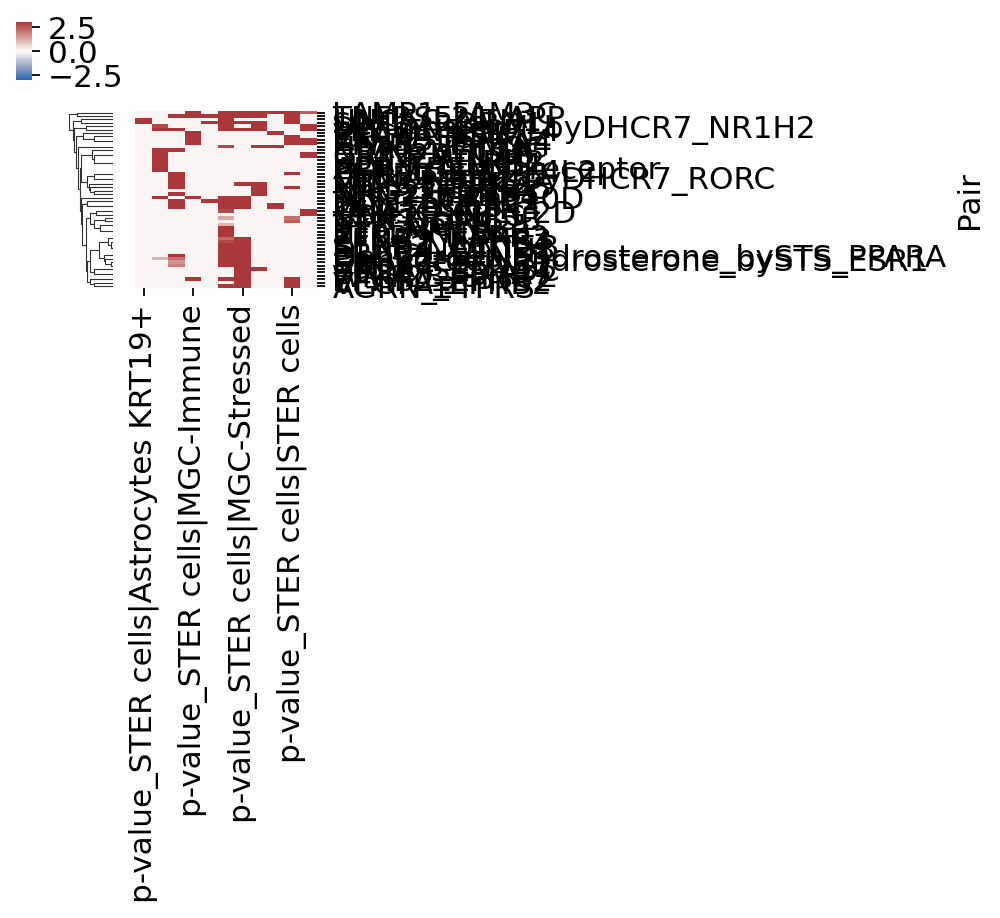

In [20]:
s=sns.clustermap(week_data_dict,row_cluster=True,col_cluster=False,
                yticklabels=True,figsize=(2,2),
               cmap='vlag',cbar_kws={'shrink': 0.5},vmin=-3,vmax=3)

In [21]:
ylabel=[i.get_text() for i in s.ax_heatmap.get_yticklabels()]
ylabels=[i for i in ylabel  if len(i)<20]
ylabels

['LAMP1_FAM3C',
 'TNFRSF21_APP',
 'UNC5C_NTN1',
 'SLIT2_ROBO1',
 'MIF_TNFRSF14',
 'VEGFA_KDR',
 'ESAM_ESAM',
 'EFNA3_EPHA4',
 'EFNB2_EPHA4',
 'HLA-C_FAM3C',
 'NRP2_VEGFA',
 'GRIN2D_IL16',
 'GRIN2A_IL16',
 'HLA-F_LILRB2',
 'HLA-F_LILRB1',
 'APP_TREM2_receptor',
 'PGRMC2_CCL4L2',
 'EFNB2_EPHB1',
 'MDK_PTPRZ1',
 'NTF3_NTRK2',
 'EFNA3_EPHA5',
 'NRG2_ERBB3',
 'NRG2_ERBB4',
 'MIF_TNFRSF10D',
 'TFF1_FGFR2',
 'MDK_LRP1',
 'UNC5B_NTN4',
 'FAM3C_CLEC2D',
 'CD47_SIRPG',
 'NTN1_UNC5B',
 'TTR_DDR1',
 'TTR_NGFR',
 'PYY_NPY1R',
 'NTF3_NTRK3',
 'PTPRS_NTRK3',
 'EFNB2_EPHB3',
 'EFNB2_EPHB4',
 'SFRP2_WNT5B',
 'DLL3_NOTCH3',
 'EPHB1_EFNB1',
 'EPHB2_EFNB1',
 'EPHA4_EFNB1',
 'NRP2_SEMA3C',
 'EFNA3_EPHA7',
 'WNT2B_SFRP2',
 'EPHB2_EFNB2',
 'VEGFA_EPHB2',
 'AGRN_PTPRS']

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


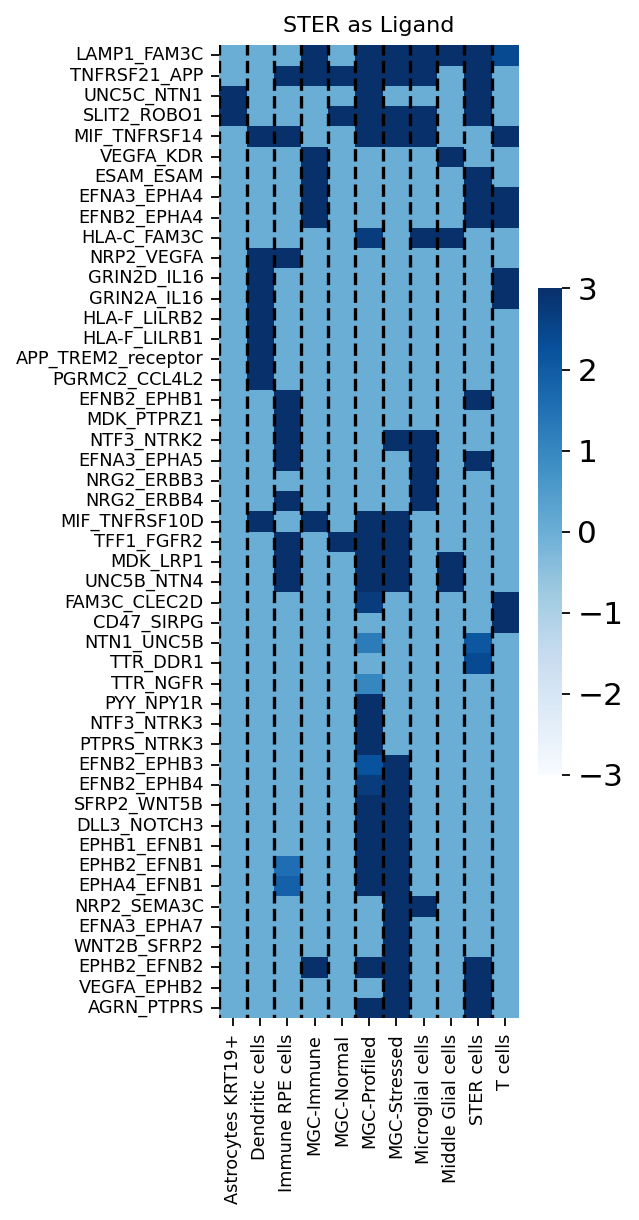

In [22]:
fig,ax=plt.subplots(figsize=(3,8))
a=sns.heatmap(week_data_dict.loc[ylabels],yticklabels=True,xticklabels=True,
                square=False,cmap='Blues',cbar_kws={'shrink': 0.5},vmin=-3,vmax=3,ax=ax)
a.set_xticklabels(a.get_xticklabels(), rotation=90,fontsize=8)
a.set_yticklabels(a.get_yticklabels(), fontsize=8)

xlabs=ax.get_xticklabels()
ax.set_xticklabels(xlabs,fontsize=8)
ylabs=ax.get_yticklabels()
ax.set_yticklabels(ylabs,fontsize=8)

[i.set_text(i.get_text().split('|')[1].replace('Lym_Neg_','').replace('Macrophage/NEUT','Macro').replace('p-value_','')) for i in xlabs]
ax.set_xticklabels(xlabs,fontsize=8)

[i.set_text(i.get_text()) for i in ylabs]
ax.set_yticklabels(ylabs,fontsize=8)
for i in range(len(xlabs)):
    if i%1==0:
        ax.axvline(x=i, ymin=-1, ymax=10,color='black',linestyle="--")
#ax.tick_params(axis='both',colors=type_color_rna['EVT'], which='both')
ax.set_ylabel('')
ax.set_title('STER as Ligand',fontsize=10)
fig.savefig(current_path+'result/analysis4/ster_cell.png',dpi=300,bbox_inches='tight')